In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from mpl_toolkits.mplot3d import Axes3D

df = pd.read_csv("../data/weatherAUS.csv")
df = df.drop(['Date', 'Location', 'WindDir9am',
             'WindGustDir', 'WindDir3pm'], axis=1)
df = df.dropna(how = 'any')
df.loc[df['RainToday'] == 'No', 'RainToday'] = 0
df.loc[df['RainToday'] == 'Yes', 'RainToday'] = 1
df.head()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
6049,17.9,35.2,0.0,12.0,12.3,48.0,6.0,20.0,20.0,13.0,1006.3,1004.4,2.0,5.0,26.6,33.4,0,No
6050,18.4,28.9,0.0,14.8,13.0,37.0,19.0,19.0,30.0,8.0,1012.9,1012.1,1.0,1.0,20.3,27.0,0,No
6052,19.4,37.6,0.0,10.8,10.6,46.0,30.0,15.0,42.0,22.0,1012.3,1009.2,1.0,6.0,28.7,34.9,0,No
6053,21.9,38.4,0.0,11.4,12.2,31.0,6.0,6.0,37.0,22.0,1012.7,1009.1,1.0,5.0,29.1,35.6,0,No
6054,24.2,41.0,0.0,11.2,8.4,35.0,17.0,13.0,19.0,15.0,1010.7,1007.4,1.0,6.0,33.6,37.6,0,No


In [2]:
X, Y = df.drop('RainTomorrow', axis=1, inplace=False), df[['RainTomorrow']]
# Normalizing Data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Converting to PyTorch tensor
X_tensor = torch.FloatTensor(X_scaled)

# Converting string labels to numerical labels
label_encoder = LabelEncoder()
Y_numerical = label_encoder.fit_transform(Y.values.ravel())

In [3]:
# Defining Autoencoder model
class Autoencoder(nn.Module):
   def __init__(self, input_size, encoding_dim):
       super(Autoencoder, self).__init__()
       self.encoder = nn.Sequential(
           nn.Linear(input_size, 16),
           nn.ReLU(),
           nn.Linear(16, encoding_dim),
           nn.ReLU()
       )
       self.decoder = nn.Sequential(
           nn.Linear(encoding_dim, 16),
           nn.ReLU(),
           nn.Linear(16, input_size),
           nn.Sigmoid()
       )

   def forward(self, x):
       x = self.encoder(x)
       x = self.decoder(x)
       return x

In [4]:
# Setting random seed for reproducibility
torch.manual_seed(42)

input_size = X.shape[1]  # Number of input features
encoding_dim = 3  # Desired number of output dimensions
model = Autoencoder(input_size, encoding_dim)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

# Training the autoencoder
num_epochs = 20
for epoch in range(num_epochs):
   # Forward pass
   outputs = model(X_tensor)
   loss = criterion(outputs, X_tensor)

   # Backward pass and optimization
   optimizer.zero_grad()
   loss.backward()
   optimizer.step()

   # Loss for each epoch
   print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# Encoding the data using the trained autoencoder
encoded_data = model.encoder(X_tensor).detach().numpy()

Epoch [1/20], Loss: 1.2443
Epoch [2/20], Loss: 1.2410
Epoch [3/20], Loss: 1.2376
Epoch [4/20], Loss: 1.2342
Epoch [5/20], Loss: 1.2307
Epoch [6/20], Loss: 1.2271
Epoch [7/20], Loss: 1.2234
Epoch [8/20], Loss: 1.2196
Epoch [9/20], Loss: 1.2156
Epoch [10/20], Loss: 1.2114
Epoch [11/20], Loss: 1.2070
Epoch [12/20], Loss: 1.2023
Epoch [13/20], Loss: 1.1974
Epoch [14/20], Loss: 1.1923
Epoch [15/20], Loss: 1.1868
Epoch [16/20], Loss: 1.1811
Epoch [17/20], Loss: 1.1751
Epoch [18/20], Loss: 1.1688
Epoch [19/20], Loss: 1.1622
Epoch [20/20], Loss: 1.1554


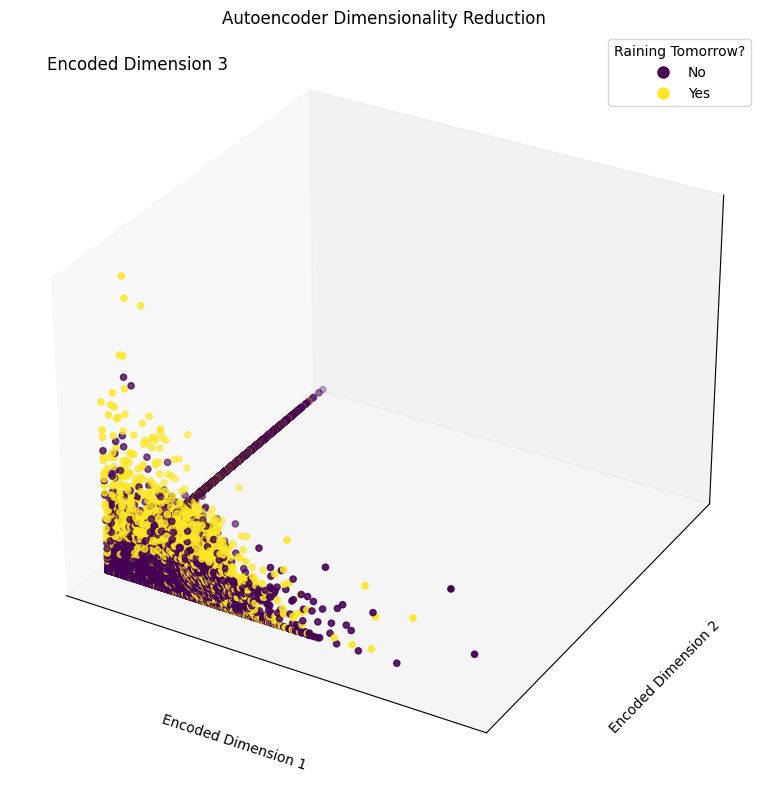

In [5]:
# Plotting the encoded data in 3D space
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(encoded_data[:, 0], encoded_data[:, 1],
                    encoded_data[:, 2], c=Y_numerical, cmap='viridis')

# Mapping numerical labels back to original string labels for the legend
labels = label_encoder.inverse_transform(np.unique(Y_numerical))
legend_labels = {num: label for num, label in zip(np.unique(Y_numerical),
                                                 labels)}

# Creating a custom legend with original string labels
handles = [plt.Line2D([0], [0], marker='o', color='w',
                    markerfacecolor=scatter.to_rgba(num),
                    markersize=10,
                    label=legend_labels[num]) for num in np.unique(Y_numerical)]
ax.legend(handles=handles, title="Raining Tomorrow?")

# Adjusting the layout to provide more space for labels
ax.xaxis.labelpad = 20
ax.yaxis.labelpad = 20

ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])

# Manually adding z-axis label for better visibility
ax.text2D(0.05, 0.95, 'Encoded Dimension 3', transform=ax.transAxes,
         fontsize=12, color='black')

ax.set_xlabel('Encoded Dimension 1')
ax.set_ylabel('Encoded Dimension 2')
ax.set_title('Autoencoder Dimensionality Reduction')

plt.tight_layout()

plt.savefig('Rain_Prediction_Autoencoder.png')

plt.show()